In [3]:
"""
Created on Wed Jul  6 14:29:39 2022
@author: suhong

Revised on Thur Jul  13 15:00:39 2022
@author: Junhyun

"""

import numpy as np
import pandas as pd
import joblib

def bootstrap_limit(stat, alpha=0.05, bootstrap=100):
    '''
        @Description
            Bootstrap sampling을 활용한 Control Limit 산출 기법

        @Parameter
            stat : 통계량 (정상상태의 데이터 입력)
            alpha : Control Limit을 정하기 위한 유의수준 (0~1)
            bootstrap : 샘플링 횟수
        @Return
            limit : 임계값 (CL : Control Limit)
    '''
    alpha = alpha*100
    alpha = 100 - alpha
    samsize = max(100, len(stat))
    
    stat = stat.reshape(len(stat)) # 2차원 array를 1차원 array로 변환
    
    # bootstrap 수 만큼 다음 작업을 반복 : samsize(최소 10000번)만큼 정상상태 데이터를 유의수준 만큼 복원 추출 후 평균 값 사용 
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    
    return limit

# import Hotellings_tsquare

class Hotellings_tsquare ():
    
    """
    Hotellings T square
    """
    
    def __init__(self) :
        
        self.tr_mu = None
        self.tr_cov = None
        self.cl = None
        
    def fit(self, trdat, alpha = 0.05) :
        """

        Parameters
        ----------
        trdat : array
            Train data
        alpha : int, 0~1
            Bootstrap Limit value. The default is 0.05.

        Returns
        -------
        trScore : array
            Train Score, 이상치 점수를 의미함. 클수록 정상패턴에서 벗어남을 의미
        CL : float
            trScore Control Limit

        """
        if isinstance(trdat,(np.ndarray)):
            trdat = pd.DataFrame(trdat)
            
        trScore = np.zeros((trdat.shape[0], 1))
        self.tr_mu = trdat.mean(axis = 0)
        self.tr_cov = trdat.cov()
        for i in range(len(trdat)):
            trScore[i] = (trdat.values[i] - self.tr_mu) @ np.linalg.pinv(self.tr_cov) @ (trdat.values[i] - self.tr_mu).transpose()
        
        self.cl = bootstrap_limit(trScore, alpha=alpha, bootstrap=100)
        
        return {'trScore' : trScore}
    
    def CL_printor(self) :
        """
        
        Returns
        -------
        CL: float
            Control Limit,
            
        """
        
        return {'CL' : self.cl}
    
    def predict(self, tsdat) :
        """

        Parameters
        ----------
        tsdat : array
            Test data. 예측 대상이 되는 데이터

        Returns
        -------
        tsScore : array
            Test data의 이상치 값

        """
        if isinstance(tsdat,(np.ndarray)):
            tsdat = pd.DataFrame(tsdat)
            
        tsScore = np.zeros((tsdat.shape[0], 1))
        
        for i in range(len(tsdat)):
            tsScore[i] = (tsdat.values[i] - self.tr_mu) @ np.linalg.pinv(self.tr_cov) @ (tsdat.values[i] - self.tr_mu).transpose()
            
        return {'tsScore' : tsScore}

In [4]:
def tsquare(trdat, tsdat, alpha=0.05):
    """

    Parameters
    ----------
    trdat : array
        Train data. 학습 대상이 되는 데이터
    tsdat : array
        Test data. 예측 대상이 되는 데이터
    alpha : float, 0~1
            Bootstrap Limit value. The default is 0.05.

    Returns
    -------
    trScore : array
        Train data의 이상치 값
    tsScore : array
        Test data의 이상치 값
    CL : float 
        Control Limit

    """
    model = Hotellings_tsquare()
    fit = model.fit(trdat, alpha=alpha)
    CL = model.CL_printor()
    pred = model.predict(tsdat)
    
    # tsquare model pickle 파일로 저장
    saved_model = joblib.dump(model, 't2.pkl')
    
    return {'trScore':fit['trScore'], 'tsScore':pred['tsScore'], 'CL': CL['CL']}
        

In [5]:
data = pd.read_csv('./data/shot6_3D365-48910.csv', encoding='euc-kr')

In [6]:
\

SyntaxError: unexpected EOF while parsing (3477860531.py, line 1)

In [ ]:
data.shape

In [ ]:
allData = pd.read_csv('./data/shot6_june.csv', encoding='euc-kr')

In [7]:
allData['불량이름'][allData['품번'] == "3D365-48910"].shape

NameError: name 'allData' is not defined

In [8]:
data = pd.concat([data,allData['불량이름'][allData['품번'] == "3D365-48910"].reset_index(drop=True)], axis=1)

NameError: name 'allData' is not defined

In [9]:
data.shape

(6893, 118)

In [10]:
removeIdx = np.where(data.describe().iloc[2,:] == 0)

In [11]:
predat = data.drop(data.columns[removeIdx], axis=1)

In [12]:
# Setting 값 제외
delSetData = predat.iloc[:,0:21]

In [13]:
print(delSetData.columns)

Index(['순번', '판정코드', '보압+사출시간', '사출시간', '계량시간', '공정시간', '형폐시간', '쿠션위치',
       '보압절환위치', '계량완료위치', '형계위치', '사출최대속도', '사출최대압력', '보압절환압력', '히터2', '히터3',
       '히터4', '히터5', '히터6', '히터7', '호퍼온도'],
      dtype='object')


In [14]:
import matplotlib.pyplot as plt
outlierIdx = np.where(delSetData['판정코드'] ==  1)[0]

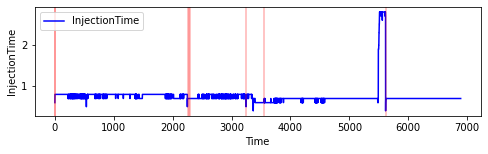

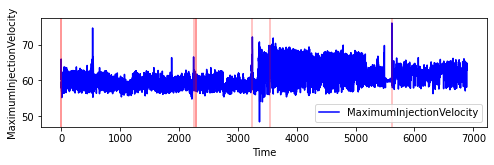

In [15]:
# 사출시간
plt.figure(figsize=(8,2))
plt.plot(delSetData['사출시간'], color='blue', label='InjectionTime')
plt.xlabel('Time')
plt.ylabel('InjectionTime')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)
    
# 사출최대속도
plt.figure(figsize=(8,2))
plt.plot(delSetData['사출최대속도'], color='blue', label='MaximumInjectionVelocity')
plt.xlabel('Time')
plt.ylabel('MaximumInjectionVelocity')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)

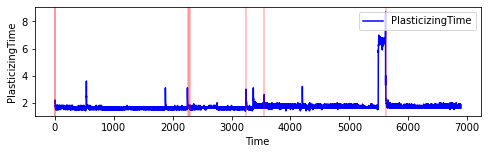

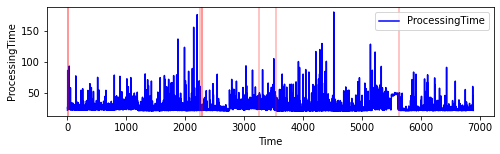

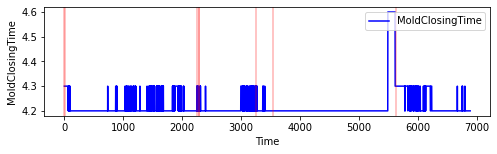

In [16]:
# 계량시간
plt.figure(figsize=(8,2))
plt.plot(delSetData['계량시간'], color='blue', label='PlasticizingTime')
plt.xlabel('Time')
plt.ylabel('PlasticizingTime')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)
    
# 공정시간
plt.figure(figsize=(8,2))
plt.plot(delSetData['공정시간'], color='blue', label='ProcessingTime')
plt.xlabel('Time')
plt.ylabel('ProcessingTime')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)
    
# 형폐시간
plt.figure(figsize=(8,2))
plt.plot(delSetData['형폐시간'], color='blue', label='MoldClosingTime')
plt.xlabel('Time')
plt.ylabel('MoldClosingTime')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)

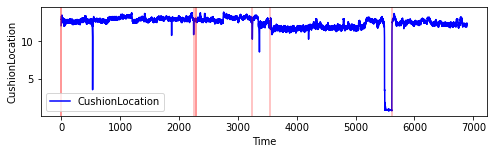

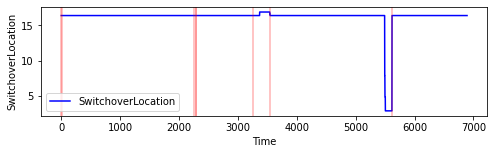

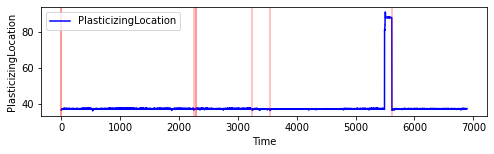

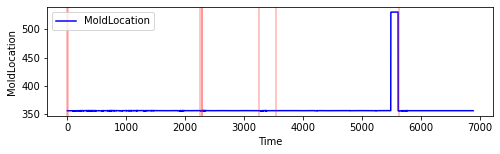

In [17]:
# 쿠션위치
plt.figure(figsize=(8,2))
plt.plot(delSetData['쿠션위치'], color='blue', label='CushionLocation')
plt.xlabel('Time')
plt.ylabel('CushionLocation')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)
    
# 보압절환위치
plt.figure(figsize=(8,2))
plt.plot(delSetData['보압절환위치'], color='blue', label='SwitchoverLocation')
plt.xlabel('Time')
plt.ylabel('SwitchoverLocation')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)
    
# 계량완료위치
plt.figure(figsize=(8,2))
plt.plot(delSetData['계량완료위치'], color='blue', label='PlasticizingLocation')
plt.xlabel('Time')
plt.ylabel('PlasticizingLocation')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)
    
# 형계위치
plt.figure(figsize=(8,2))
plt.plot(delSetData['형계위치'], color='blue', label='MoldLocation')
plt.xlabel('Time')
plt.ylabel('MoldLocation')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)

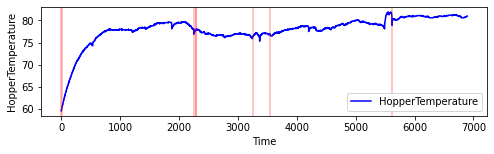

In [18]:
# 호퍼 온도
plt.figure(figsize=(8,2))
plt.plot(delSetData['호퍼온도'], color='blue', label='HopperTemperature')
plt.xlabel('Time')
plt.ylabel('HopperTemperature')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)

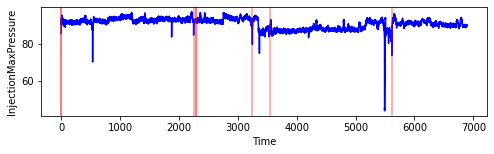

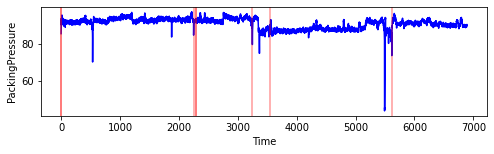

In [19]:
plt.figure(figsize=(8,2))
# 사출최대압력
plt.plot(delSetData['사출최대압력'], label='InjectionMaxPressure', color='blue')
plt.xlabel('Time')
plt.ylabel('InjectionMaxPressure')
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.4)
plt.show()

# 보압절환압력
plt.figure(figsize=(8,2))
plt.plot(delSetData['보압절환압력'], label='PackingPressure', color='blue')
plt.xlabel('Time')
plt.ylabel('PackingPressure')
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.4)
plt.show()


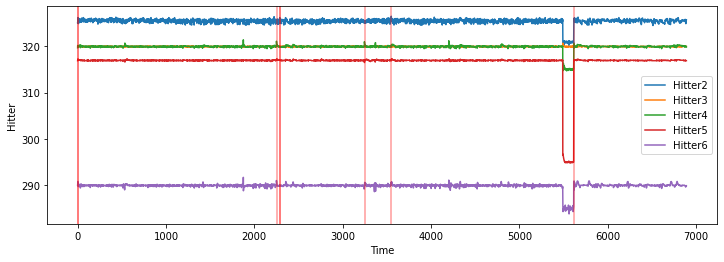

In [20]:
plt.figure(figsize=(12,4))
plt.plot(delSetData['히터2'], label='Hitter2')
plt.plot(delSetData['히터3'], label='Hitter3')
plt.plot(delSetData['히터4'], label='Hitter4')
plt.plot(delSetData['히터5'], label='Hitter5')
plt.plot(delSetData['히터6'], label='Hitter6')
# plt.plot(delSetData['히터7'], label='Hitter7')
plt.xlabel('Time')
plt.ylabel('Hitter')
plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.4)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(delSetData)
scaledData = scaler.transform(delSetData)

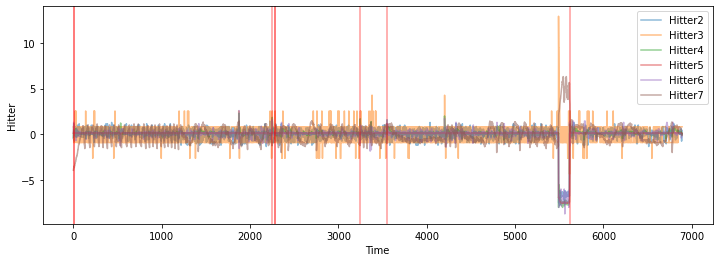

In [22]:
# Scaled
plt.figure(figsize=(12,4))
plt.plot(scaledData[:,14], label='Hitter2', alpha=0.5)
plt.plot(scaledData[:,15], label='Hitter3', alpha=0.5)
plt.plot(scaledData[:,16], label='Hitter4', alpha=0.5)
plt.plot(scaledData[:,17], label='Hitter5', alpha=0.5)
plt.plot(scaledData[:,18], label='Hitter6', alpha=0.5)
plt.plot(scaledData[:,19], label='Hitter7', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Hitter')

plt.legend()
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.4)

In [23]:
from sklearn.model_selection import train_test_split

indata = delSetData[delSetData['판정코드'] == 0]

trdat, test = train_test_split(indata, test_size=0.2)

In [24]:
tsq = tsquare(trdat.iloc[:,2:], delSetData.iloc[:,2:], alpha=0.05)

In [25]:
print(predat['불량이름'][outlierIdx])
col = ['red', 'orange', 'red','red','red','red','purple','orange']
print(col)

KeyError: '불량이름'

NameError: name 'col' is not defined

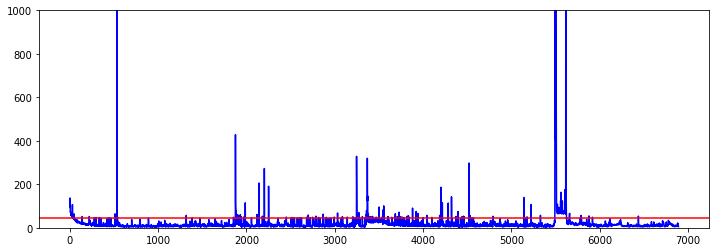

In [26]:
plt.figure(figsize=(12,4))
plt.plot(tsq['tsScore'], color='blue')
#plt.xlim([3000,4000])
plt.ylim([0,1000])
plt.axhline(y=tsq['CL'], color='red')
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color=col[i], alpha=0.3)
plt.axhline(y=-100, label="SHORT SHOT", color='red', alpha=0.3)
plt.axhline(y=-100, label="GAS", color='orange', alpha=0.3)
plt.axhline(y=-100, label="BURR", color='purple', alpha=0.3)
plt.legend()
plt.show()

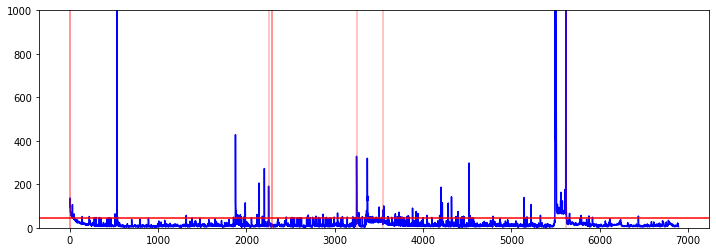

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(tsq['tsScore'], color='blue')
#plt.xlim([3000,4000])
plt.ylim([0,1000])
plt.axhline(y=tsq['CL'], color='red')
for i in range(len(outlierIdx)):
    plt.axvline(x=outlierIdx[i], color='red', alpha=0.3)
plt.show()